# Imports and hyperparameters

In [1]:
import copy
import wandb
import os

import lightning as l
import torch
import torchvision
import torchmetrics
from torch import nn
import matplotlib.pyplot as plt

from lightly.data import LightlyDataset
from lightly.loss.vicreg_loss import VICRegLoss
from lightly.models.modules.heads import VICRegProjectionHead
from lightly.transforms.vicreg_transform import VICRegTransform
from lightly.models.utils import (
    batch_shuffle,
    batch_unshuffle,
    deactivate_requires_grad,
    update_momentum,
)
from lightly.transforms import utils

C:\Users\illya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: illyan (nest-ai). Use `wandb login --relogin` to force relogin


True

In [3]:
num_workers = os.cpu_count()
batch_size = 512
memory_bank_size = 4096
seed = 1
max_epochs = 100
data_dir = '../data/'
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

In [4]:
path_to_train = data_dir + "100-bird-species/train/"
path_to_valid = data_dir + "100-bird-species/valid/"
path_to_test = data_dir + "100-bird-species/test/"

In [5]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder(path_to_train)
num_classes = len(dataset.classes)
print(num_classes)

525


In [6]:
l.seed_everything(seed)

Seed set to 1


1

# Datasets

In [7]:
train_vicreg_transform = VICRegTransform(
    input_size=32,
    gaussian_blur=0.0,
)

train_classifier_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

# No additional augmentations for the test set
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

In [8]:
dataset_train_vicreg = LightlyDataset(input_dir=path_to_train, transform=train_vicreg_transform)

dataset_train_classifier = LightlyDataset(
    input_dir=path_to_train, transform=train_classifier_transforms
)

dataset_valid = LightlyDataset(input_dir=path_to_valid, transform=test_transforms)
dataset_test = LightlyDataset(input_dir=path_to_test, transform=test_transforms)

In [9]:
dataloader_train_vicreg = torch.utils.data.DataLoader(
    dataset_train_vicreg,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    persistent_workers=True,
)

dataloader_train_classifier = torch.utils.data.DataLoader(
    dataset_train_classifier,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    persistent_workers=True,
)

dataloader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    persistent_workers=True,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    persistent_workers=True,
)

# VICReg class 
SSL-method with pretrained resnet18 backbone

In [10]:
class VICReg(l.LightningModule):
    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.projection_head = VICRegProjectionHead(
            input_dim=512,
            hidden_dim=2048,
            output_dim=2048,
            num_layers=4,
        )
        self.criterion = VICRegLoss()

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

    def training_step(self, batch, batch_index):
        (x0, x1) = batch[0]
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("vicreg_loss", loss, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.adam.Adam(self.parameters(), lr=0.06)
        return optim

# Classifier class
Defining one classification layer after the backbone

In [11]:
class Classifier(l.LightningModule):
    def __init__(self, backbone, num_classes):
        super().__init__()
        # use the pretrained ResNet backbone
        self.backbone = backbone

        # freeze the backbone
        deactivate_requires_grad(backbone)

        # create a linear layer for our downstream classification model
        self.fc = nn.Linear(512, num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.validation_step_outputs = []

    def forward(self, x):
        y_hat = self.backbone(x).flatten(start_dim=1)
        y_hat = self.fc(y_hat)
        return y_hat

    def training_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log("classifier_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self.forward(x)
        y_hat = torch.nn.functional.softmax(y_hat, dim=1)

        _, predicted = torch.max(y_hat, 1)
        num = predicted.shape[0]
        correct = (predicted == y).float().sum()
        self.validation_step_outputs.append((num, correct))
        return num, correct

    def on_validation_epoch_end(self):
        if self.validation_step_outputs:
            total_num = 0
            total_correct = 0
            for num, correct in self.validation_step_outputs:
                total_num += num
                total_correct += correct
            acc = total_correct / total_num
            self.log("val_acc", acc, on_epoch=True, prog_bar=True)
            self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self(x)

        loss = self.criterion(y_hat, y)
        accuracy = self.accuracy(y_hat, y)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self(x)
        return (y_hat, y)

    def configure_optimizers(self):
        optim = torch.optim.adam.Adam(self.fc.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

# Training

## VICReg training
You can skip this and load a trained model from checkpoint in the next cell

(If you have an entire trained model in checkpoint, you can skip the next 3 cells and load the model in just one step)

In [12]:
wandb_logger = l.pytorch.loggers.WandbLogger(
    name="VICReg", project="Self-supervised learning in-the-wild"
)
callback = l.pytorch.callbacks.ModelCheckpoint(
    monitor='vicreg_loss',
    mode='min',
    dirpath = './models/',
    filename = 'best_model_vicreg',
)

model = VICReg()
trainer = l.pytorch.Trainer(
    max_epochs=max_epochs, devices=1, accelerator=accelerator, logger=[wandb_logger], callbacks=[callback]
)
trainer.fit(model=model, train_dataloaders=dataloader_train_vicreg)

wandb.finish()

C:\Users\illya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\illya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device

C:\Users\illya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:639: Checkpoint directory ./models/ exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


AttributeError: module 'torch.optim' has no attribute 'adam'

In [ ]:
# Before running change ckpt_path to the correct one
# ckpt_path = "models/best_model_vicreg.ckpt"

# model = VICReg()
# model.load_state_dict(torch.load(ckpt_path, map_location=torch.device('cpu'))['state_dict'])

## Classifier training
You can also skip this step and load the entire trained model from checkpoint in the next cell

In [ ]:
wandb_logger = l.pytorch.loggers.WandbLogger(
    name="Classifier", project="Self-supervised learning in-the-wild"
)
callback = l.pytorch.callbacks.ModelCheckpoint(
    monitor='val_acc',
    mode='max',
    dirpath = './models/',
    filename = 'best_model_with_classifier',
)

model.eval()
classifier = Classifier(model.backbone, num_classes)
trainer = l.pytorch.Trainer(
    max_epochs=max_epochs, devices=1, accelerator=accelerator, logger=[wandb_logger], callbacks=[callback]
)
trainer.fit(classifier, dataloader_train_classifier, dataloader_valid)

wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


C:\Users\illya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:639: Checkpoint directory ./models/ exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


AttributeError: module 'torch.optim' has no attribute 'adamw'

In [ ]:
# Before running change ckpt_with_classifier_path to the correct one
# ckpt_with_classifier_path = "models/best_model_with_classifier.ckpt"

# model = VICReg()
# classifier = Classifier(model.backbone, num_classes)
# classifier.load_state_dict(torch.load(ckpt_with_classifier_path, map_location=torch.device('cpu'))['state_dict'])

# Evaluation

## Accuracy on test dataset

In [ ]:
wandb_logger = l.pytorch.loggers.WandbLogger(
    name="Classifier", project="Self-supervised learning in-the-wild"
)
callback = l.pytorch.callbacks.ModelCheckpoint(
    monitor='val_acc',
    mode='max'
)
trainer = l.pytorch.Trainer(
    max_epochs=max_epochs, devices=1, accelerator=accelerator, logger=[wandb_logger], callbacks=[callback]
)

classifier.eval()
trainer.validate(classifier, dataloader_test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 184.50it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.07238095253705978    │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.07238095253705978}]

## Confusion matrix

In [ ]:
def evaluate_model(model, dataloader, num_classes):
    confusion_matrix_metric = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=num_classes)
    model.eval()
    with torch.no_grad():
        for y_hat, y in trainer.predict(model, dataloader):
            confusion_matrix_metric(y_hat.softmax(dim=-1), y)
    confusion_matrix = confusion_matrix_metric.compute()
    return confusion_matrix

confusion_matrix = evaluate_model(classifier, dataloader_test, num_classes)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 141.07it/s]


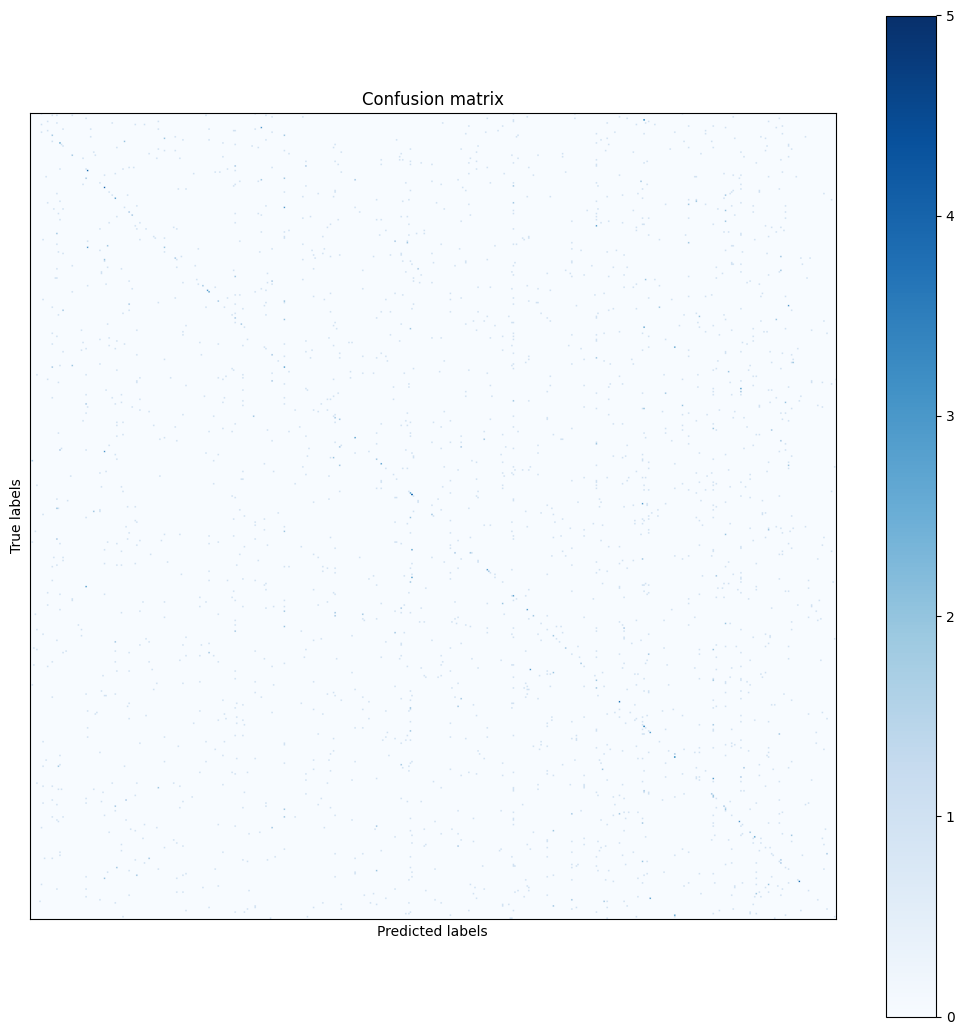

In [ ]:
plt.figure(figsize=(13,13))
plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix')
plt.colorbar()
plt.show()
plt.close()